In [1]:
#importing library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import os
from prophet import Prophet

from datetime import timedelta


# Statsmodels and sklearn
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings 
warnings.filterwarnings("ignore")

In [2]:
#loadin dataset
df = pd.read_csv("D:/DA/NFT Market Trends/NFTlyze Dataset.csv")

In [3]:
print(df.head(5))

         Date  Sales_USD_cumsum  Number_of_Sales_cumsum  \
0  22-06-2017              0.00                       0   
1  23-06-2017           1020.30                      19   
2  24-06-2017           2261.14                      40   
3  25-06-2017           2778.69                      53   
4  26-06-2017           3203.32                      67   

   Active_Market_Wallets_cumsum  Primary_Sales_cumsum  Secondary_Sales_cumsum  \
0                           0.0                     0                     NaN   
1                           8.0                     0                    19.0   
2                          21.0                     0                    21.0   
3                          28.0                     0                    13.0   
4                          34.0                     0                    14.0   

   AverageUSD_cum  Sales_USD  Number_of_Sales  Active_Market_Wallets  \
0             NaN        NaN              NaN                    NaN   
1           53

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          1606 non-null   object 
 1   Sales_USD_cumsum              1606 non-null   float64
 2   Number_of_Sales_cumsum        1606 non-null   int64  
 3   Active_Market_Wallets_cumsum  1598 non-null   float64
 4   Primary_Sales_cumsum          1606 non-null   int64  
 5   Secondary_Sales_cumsum        1605 non-null   float64
 6   AverageUSD_cum                1605 non-null   float64
 7   Sales_USD                     1605 non-null   float64
 8   Number_of_Sales               1605 non-null   float64
 9   Active_Market_Wallets         1597 non-null   float64
 10  Primary_Sales                 1605 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 138.1+ KB
None


In [5]:
print(df.isna().sum())

Date                            0
Sales_USD_cumsum                0
Number_of_Sales_cumsum          0
Active_Market_Wallets_cumsum    8
Primary_Sales_cumsum            0
Secondary_Sales_cumsum          1
AverageUSD_cum                  1
Sales_USD                       1
Number_of_Sales                 1
Active_Market_Wallets           9
Primary_Sales                   1
dtype: int64


In [6]:
# Convert Date column
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

# Sort by date
df = df.sort_values('Date')

# Drop rows with missing Sales_USD
df = df.dropna(subset=['Sales_USD'])

# Create daily series for forecasting
daily_sales = df.set_index('Date')['Sales_USD']

print(daily_sales.head())
print(daily_sales.describe())

Date
2017-06-23    1020.30
2017-06-24    1240.84
2017-06-25     517.55
2017-06-26     424.63
2017-06-27    2092.91
Name: Sales_USD, dtype: float64
count    1.605000e+03
mean     6.372813e+06
std      2.486102e+07
min     -6.196720e+06
25%      4.605234e+04
50%      8.218757e+04
75%      3.528744e+05
max      3.886364e+08
Name: Sales_USD, dtype: float64


# Exploratory Data Analysis (EDA)

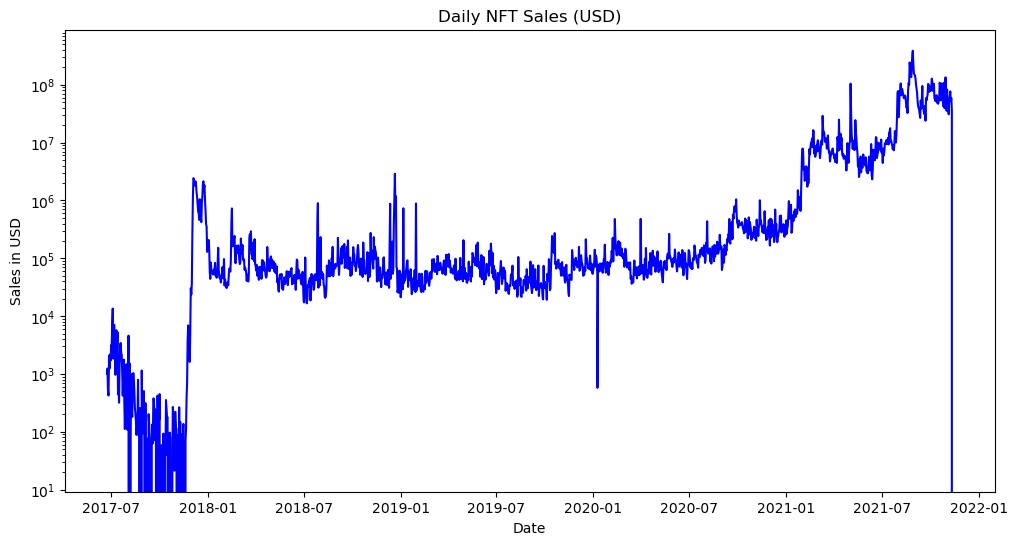

In [7]:
plt.figure(figsize=(12,6))
plt.plot(daily_sales, color="blue")
plt.title("Daily NFT Sales (USD)")
plt.xlabel("Date")
plt.ylabel("Sales in USD")
plt.yscale("log")  # log scale helps with extreme spikes
plt.show()

In [8]:
# Replace negative sales with 0
daily_sales = daily_sales.clip(lower=0)

# Optional: Winsorize extreme outliers (cap top 1%)
cap = daily_sales.quantile(0.99)
daily_sales = daily_sales.clip(upper=cap)

print(daily_sales.describe())

count    1.605000e+03
mean     5.619048e+06
std      1.858724e+07
min      0.000000e+00
25%      4.605234e+04
50%      8.218757e+04
75%      3.528744e+05
max      1.082339e+08
Name: Sales_USD, dtype: float64


In [9]:
train = daily_sales.iloc[:-30]
test = daily_sales.iloc[-30:]

print("Train range:", train.index.min(), "to", train.index.max())
print("Test range:", test.index.min(), "to", test.index.max())

Train range: 2017-06-23 00:00:00 to 2021-10-13 00:00:00
Test range: 2021-10-14 00:00:00 to 2021-11-12 00:00:00


In [10]:
# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate to daily sales (sum if multiple entries per day)
daily_sales = df.groupby('Date')['Sales_USD'].sum()

# Now no duplicates -> set frequency
daily_sales = daily_sales.asfreq('D', fill_value=0)  # fill missing days with 0

NameError: name 'forecast' is not defined

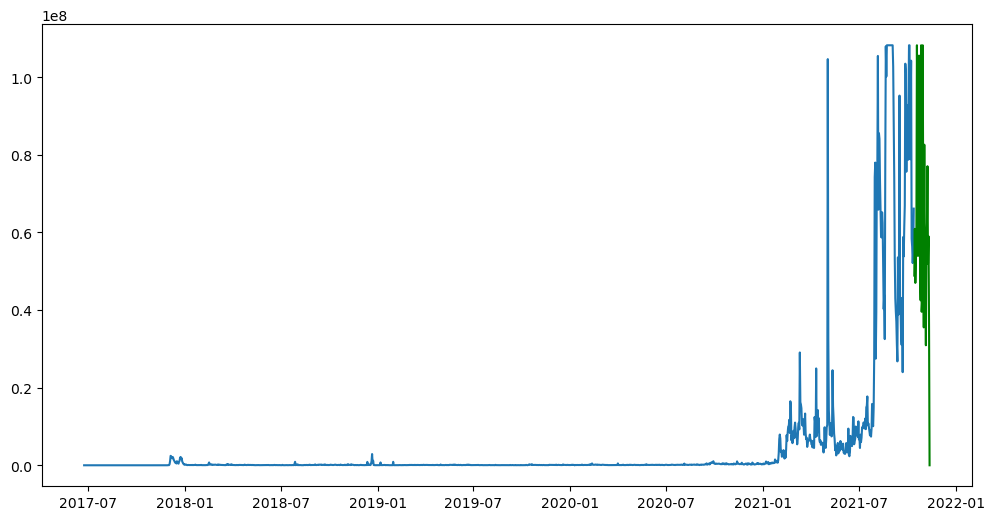

In [11]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="green")
plt.plot(forecast, label="Forecast", color="red")
plt.title("NFT Daily Sales Forecast (ETS, trend only)")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.show()

In [12]:
# Clip negative sales to 0
train_clip = train.clip(lower=0)
test_clip = test.clip(lower=0)

# Apply log1p safely
train_log = np.log1p(train_clip)
test_log = np.log1p(test_clip)

print("Train log min:", train_log.min())
print("Test log min:", test_log.min())

Train log min: 0.0
Test log min: 0.0


In [13]:
# Fit ETS on log-transformed data
ets_log = ExponentialSmoothing(train_log, trend="add", seasonal=None, initialization_method="estimated").fit()

# Forecast in log space
forecast_log = ets_log.forecast(len(test_log))

# Inverse transform back to original scale
forecast = np.expm1(forecast_log)
forecast = pd.Series(forecast, index=test.index, name="forecast")

In [14]:
# Evaluate log-transformed ETS forecast
y_true = test.values
y_pred = forecast.values

# Safety: handle NaNs or infs
y_true = np.nan_to_num(y_true, nan=0.0, posinf=0.0, neginf=0.0)
y_pred = np.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Log-ETS MAE: {mae:,.2f}")
print(f"Log-ETS RMSE: {rmse:,.2f}")

Log-ETS MAE: 59,859,153.19
Log-ETS RMSE: 64,853,777.90


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()

In [16]:
print(df.columns)

Index(['Sales_USD_cumsum', 'Number_of_Sales_cumsum',
       'Active_Market_Wallets_cumsum', 'Primary_Sales_cumsum',
       'Secondary_Sales_cumsum', 'AverageUSD_cum', 'Sales_USD',
       'Number_of_Sales', 'Active_Market_Wallets', 'Primary_Sales'],
      dtype='object')


In [17]:
df['Sales_USD_cumsum'] = df['Sales_USD'].cumsum()
df['Primary_Sales_cumsum'] = df['Primary_Sales'].cumsum()

# Only compute Secondary if column exists
if 'Secondary_Sales' in df.columns:
    df['Secondary_Sales_cumsum'] = df['Secondary_Sales'].cumsum()
else:
    df['Secondary_Sales_cumsum'] = None  # or skip plotting

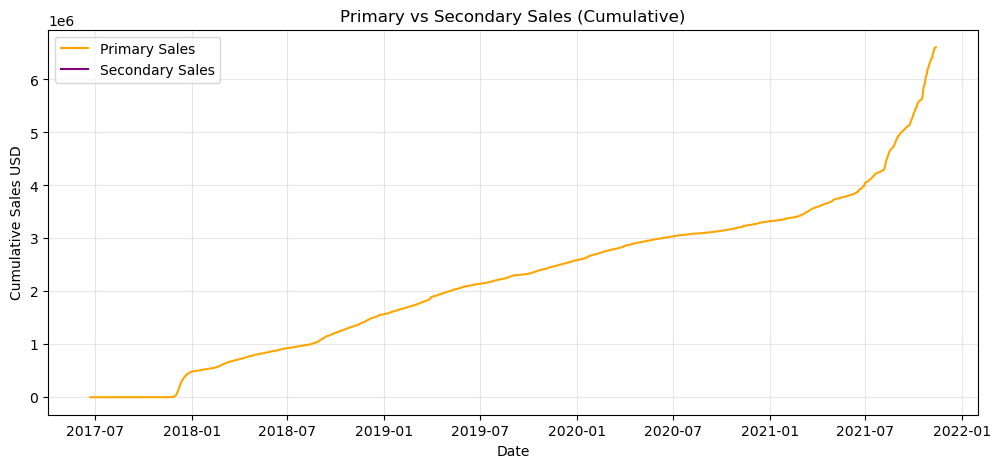

In [18]:
# Use existing cumulative columns, no need to recompute
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Primary_Sales_cumsum'], label='Primary Sales', color='orange')
plt.plot(df.index, df['Secondary_Sales_cumsum'], label='Secondary Sales', color='purple')
plt.title('Primary vs Secondary Sales (Cumulative)')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales USD')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

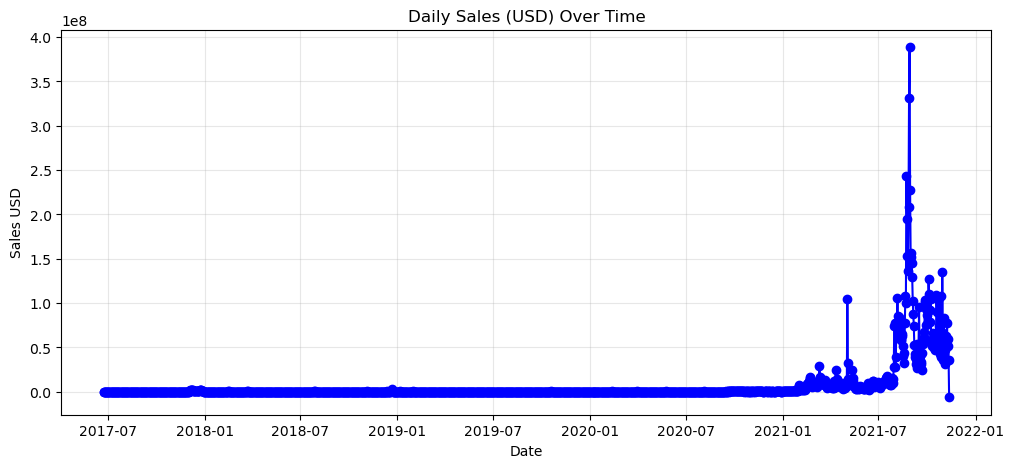

In [19]:
# Daily Sales (USD) over time

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Sales_USD'], marker='o', linestyle='-', color='blue')
plt.title('Daily Sales (USD) Over Time')
plt.xlabel('Date')
plt.ylabel('Sales USD')
plt.grid(alpha=0.3)
plt.show()

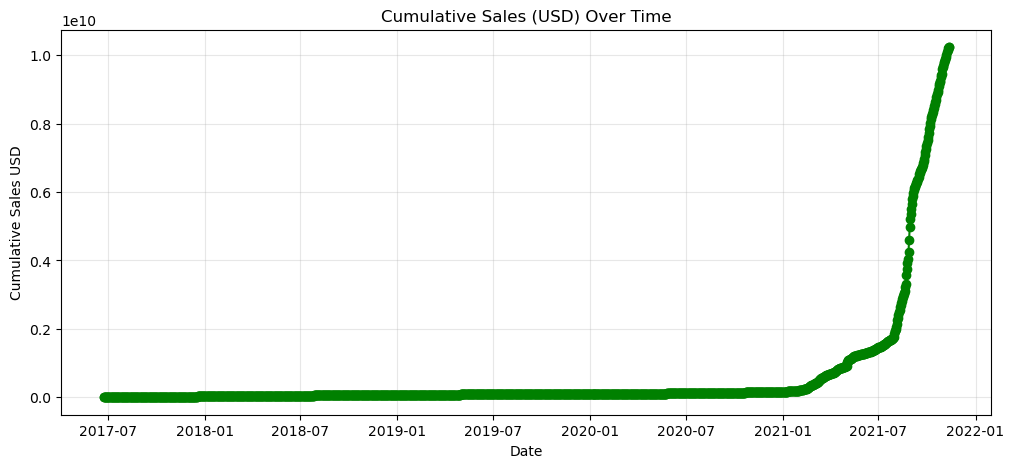

In [20]:
# Cumulative Sales (USD) over time

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Sales_USD_cumsum'], marker='o', linestyle='-', color='green')
plt.title('Cumulative Sales (USD) Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales USD')
plt.grid(alpha=0.3)
plt.show()

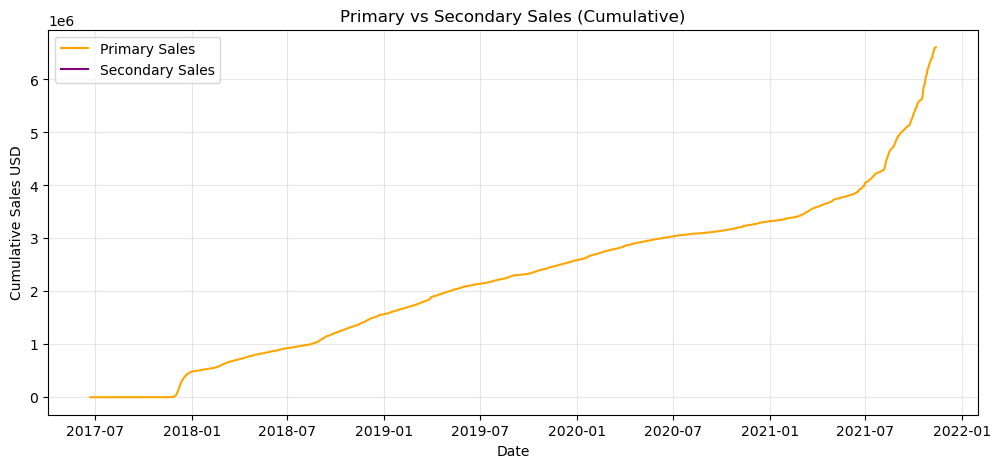

In [21]:
#  Primary vs Secondary Sales (Cumulative)

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Primary_Sales_cumsum'], label='Primary Sales', color='orange')
plt.plot(df.index, df['Secondary_Sales_cumsum'], label='Secondary Sales', color='purple')
plt.title('Primary vs Secondary Sales (Cumulative)')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales USD')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

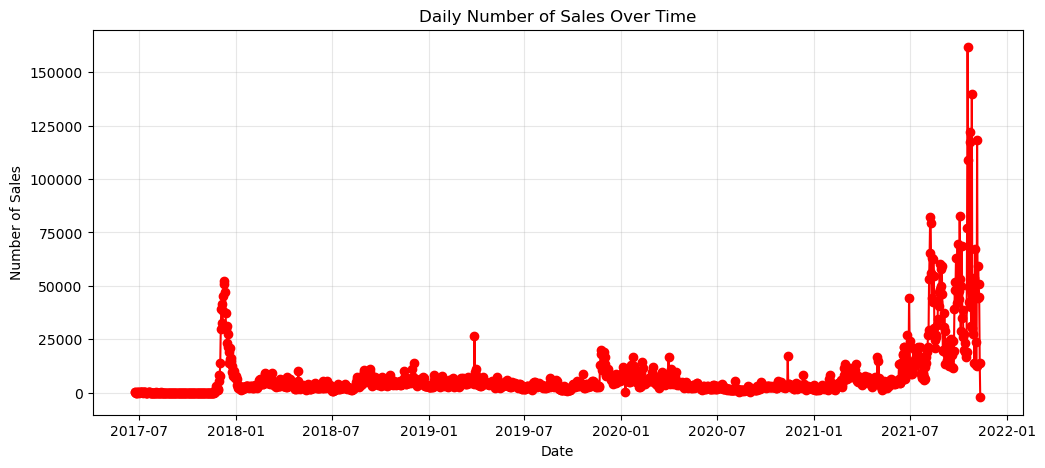

In [22]:
# Daily Number of Sales over time

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Number_of_Sales'], marker='o', linestyle='-', color='red')
plt.title('Daily Number of Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.grid(alpha=0.3)
plt.show()

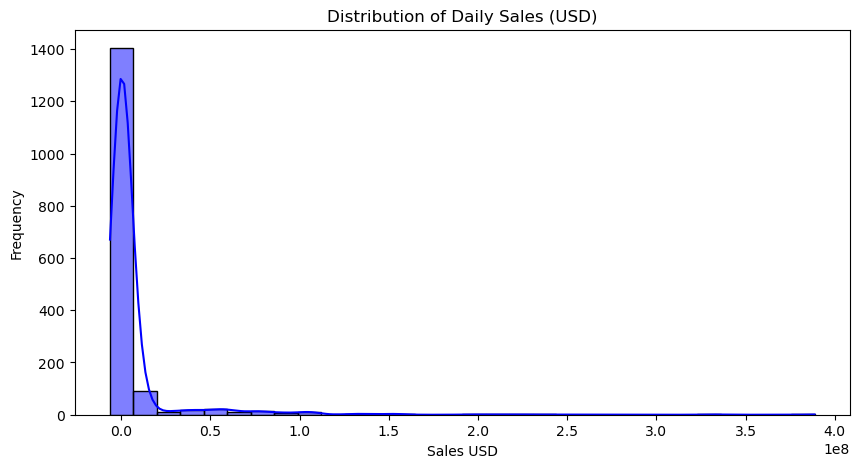

In [23]:
# Distribution of daily Sales (USD)

plt.figure(figsize=(10,5))
sns.histplot(df['Sales_USD'], bins=30, kde=True, color='blue')
plt.title('Distribution of Daily Sales (USD)')
plt.xlabel('Sales USD')
plt.ylabel('Frequency')
plt.show()

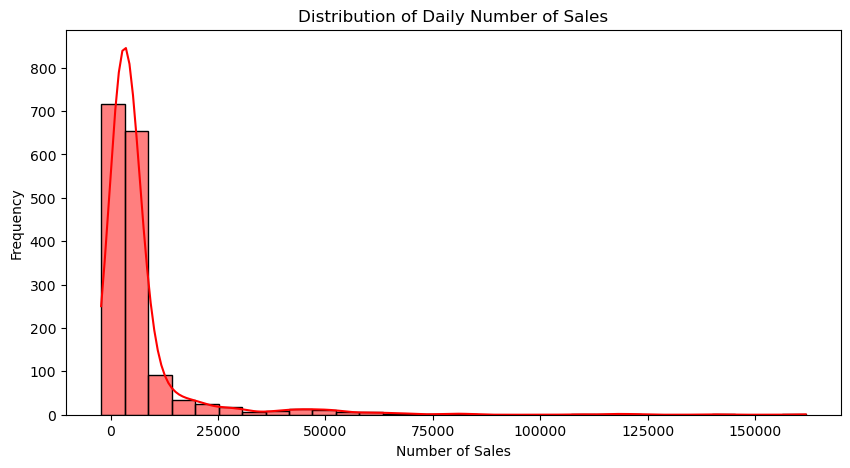

In [24]:
# Distribution of daily Number of Sales

plt.figure(figsize=(10,5))
sns.histplot(df['Number_of_Sales'], bins=30, kde=True, color='red')
plt.title('Distribution of Daily Number of Sales')
plt.xlabel('Number of Sales')
plt.ylabel('Frequency')
plt.show()

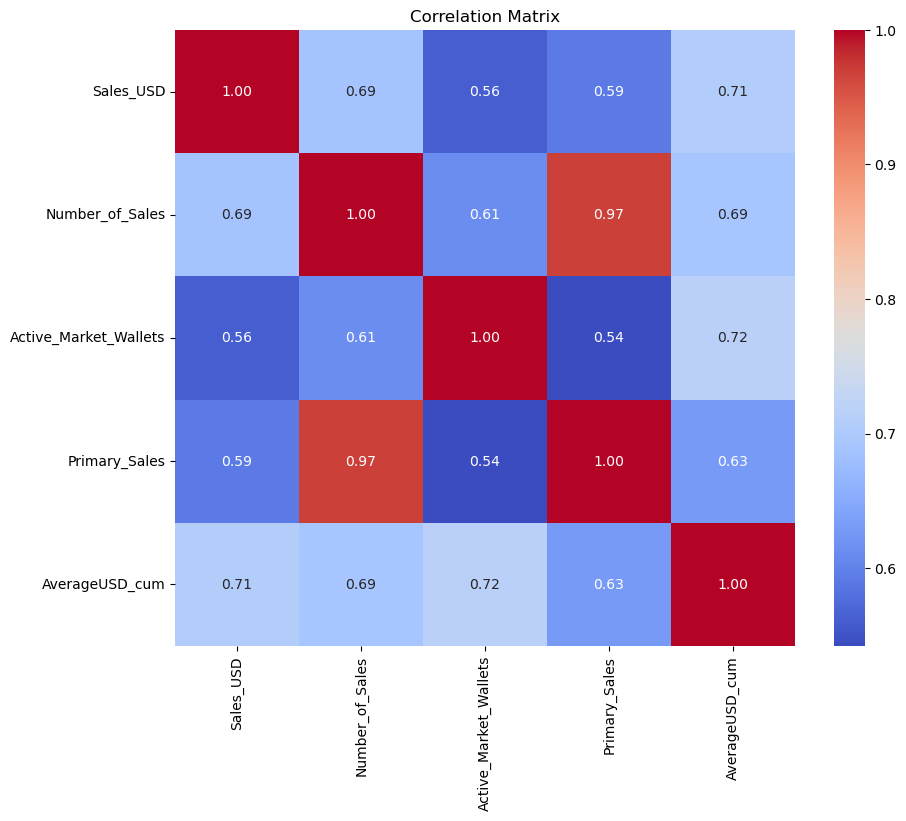

In [25]:
# Correlation Matrix

corr_columns = ['Sales_USD', 'Number_of_Sales', 'Active_Market_Wallets', 'Primary_Sales', 'AverageUSD_cum']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

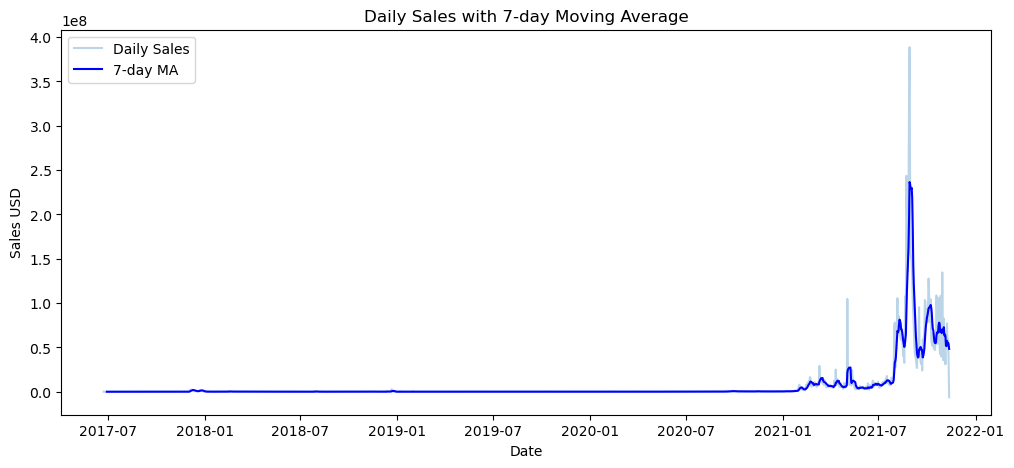

In [26]:
# Moving Average

df['Sales_USD_MA7'] = df['Sales_USD'].rolling(7).mean()
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Sales_USD'], alpha=0.3, label='Daily Sales')
plt.plot(df.index, df['Sales_USD_MA7'], color='blue', label='7-day MA')
plt.title('Daily Sales with 7-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Sales USD')
plt.legend()
plt.show()

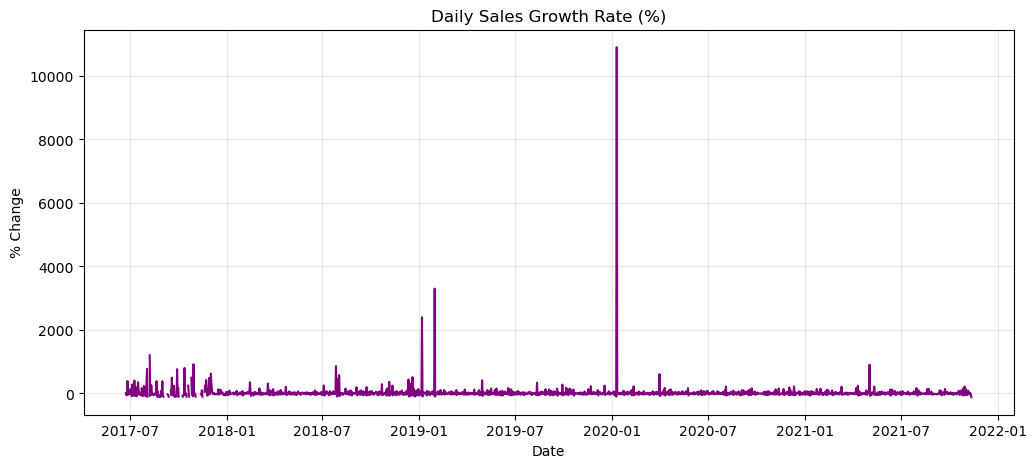

In [27]:
# Daily % Change

df['Sales_USD_pct_change'] = df['Sales_USD'].pct_change() * 100
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Sales_USD_pct_change'], color='purple')
plt.title('Daily Sales Growth Rate (%)')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.grid(True, alpha=0.3)
plt.show()

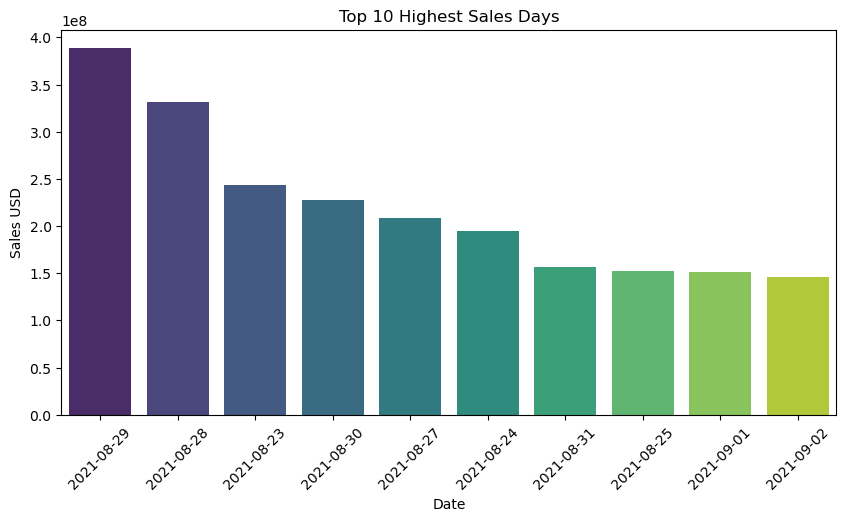

In [28]:
# Top N Days

top_days = df.nlargest(10, 'Sales_USD')
plt.figure(figsize=(10,5))
sns.barplot(x=top_days.index.date, y=top_days['Sales_USD'], palette='viridis')
plt.title('Top 10 Highest Sales Days')
plt.xlabel('Date')
plt.ylabel('Sales USD')
plt.xticks(rotation=45)
plt.show()

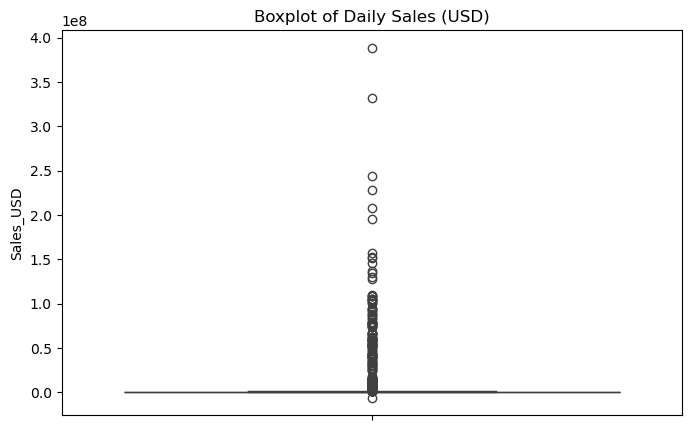

In [29]:
# Boxplots

plt.figure(figsize=(8,5))
sns.boxplot(y=df['Sales_USD'])
plt.title('Boxplot of Daily Sales (USD)')
plt.show()

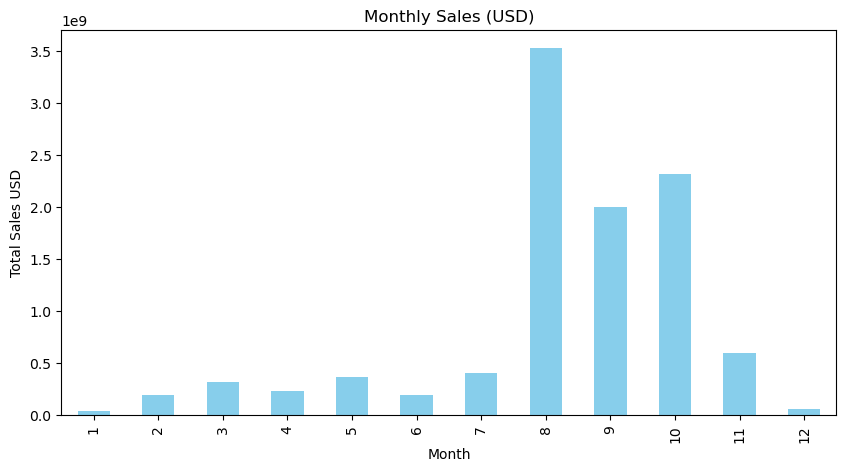

In [30]:
# Month-wise Analysis

df['Month'] = df.index.month
monthly_sales = df.groupby('Month')['Sales_USD'].sum()
monthly_sales.plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title('Monthly Sales (USD)')
plt.xlabel('Month')
plt.ylabel('Total Sales USD')
plt.show()

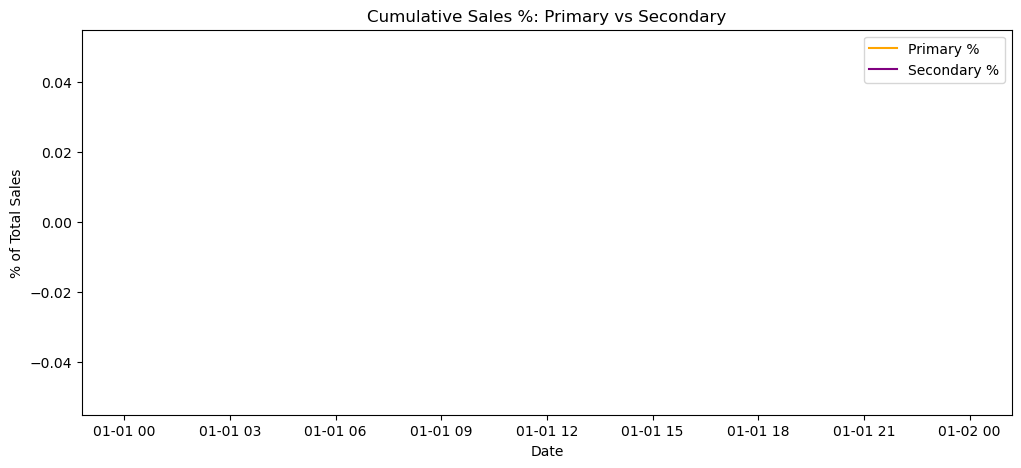

In [31]:
# Cumulative % Contribution

df['Total_cumsum'] = df['Primary_Sales_cumsum'] + df['Secondary_Sales_cumsum']
df['Primary_pct'] = df['Primary_Sales_cumsum'] / df['Total_cumsum'] * 100
df['Secondary_pct'] = df['Secondary_Sales_cumsum'] / df['Total_cumsum'] * 100

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Primary_pct'], label='Primary %', color='orange')
plt.plot(df.index, df['Secondary_pct'], label='Secondary %', color='purple')
plt.title('Cumulative Sales %: Primary vs Secondary')
plt.ylabel('% of Total Sales')
plt.xlabel('Date')
plt.legend()
plt.show()

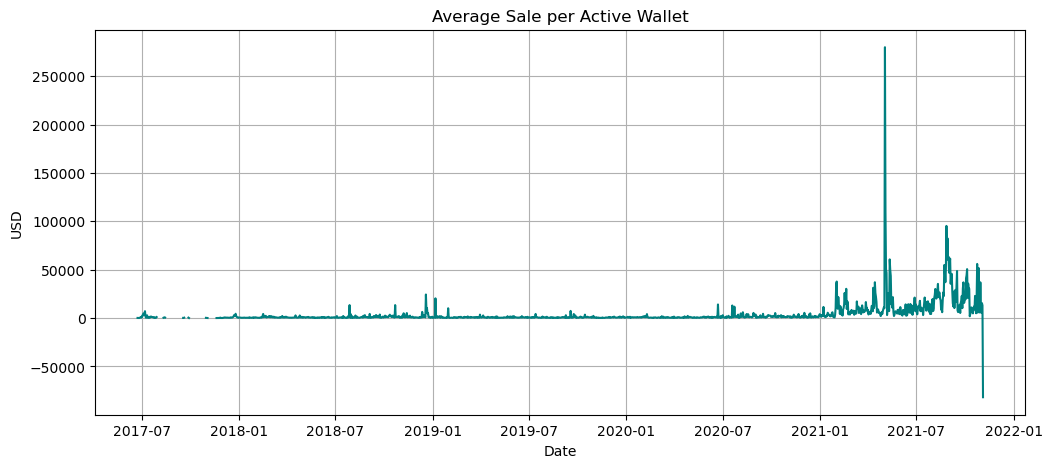

In [32]:
# Advanced: NFT Price Distribution per Active Wallet

df['Avg_Sale_per_Wallet'] = df['Sales_USD'] / df['Active_Market_Wallets']
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Avg_Sale_per_Wallet'], color='teal')
plt.title('Average Sale per Active Wallet')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)
plt.show()

In [33]:
print(df.index)

DatetimeIndex(['2017-06-23', '2017-06-24', '2017-06-25', '2017-06-26',
               '2017-06-27', '2017-06-28', '2017-06-29', '2017-06-30',
               '2017-07-01', '2017-07-02',
               ...
               '2021-11-03', '2021-11-04', '2021-11-05', '2021-11-06',
               '2021-11-07', '2021-11-08', '2021-11-09', '2021-11-10',
               '2021-11-11', '2021-11-12'],
              dtype='datetime64[ns]', name='Date', length=1605, freq=None)


In [34]:
# Make sure index is datetime
df.index = pd.to_datetime(df.index)

# Aggregate Sales_USD by date (sum if duplicates)
df_model = df[['Sales_USD']].groupby(df.index).sum()

# Ensure daily frequency
df_model = df_model.asfreq('D')

# Fill missing dates
df_model = df_model.fillna(method='ffill')

# Check
df_model.head()

,Sales_USD
Date,
2017-06-23,1020.30
2017-06-24,1240.84
2017-06-25,517.55
2017-06-26,424.63
2017-06-27,2092.91


In [35]:
# # Prepare data

df = df[~df.index.duplicated(keep='first')]
df_daily = df.asfreq('D', method='ffill')

In [36]:
df_model = df_daily[['Sales_USD']].copy()

In [37]:
df_model['Sales_USD_k'] = df_model['Sales_USD'] / 1000

In [38]:
# Train-test split (last 90 days for testing)

train = df_model.iloc[:-90]
test = df_model.iloc[-90:]

In [39]:
# Fit Prophet

df_prophet = train.reset_index().rename(columns={'Date': 'ds', 'Sales_USD_k': 'y'})
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(df_prophet)

00:40:40 - cmdstanpy - INFO - Chain [1] start processing
00:40:40 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Forecast future (test period + 30 days)

future = model.make_future_dataframe(periods=len(test)+30)
forecast = model.predict(future)

In [41]:
# Align test index with forecast
preds = forecast.set_index('ds').reindex(test.index)['yhat']

In [42]:
# Scale back to original units
preds_orig = preds * 1000
y_true_orig = test['Sales_USD']

mae = mean_absolute_error(y_true_orig, preds_orig)
rmse = np.sqrt(mean_squared_error(y_true_orig, preds_orig))
print(f"Prophet → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Prophet → MAE: 57935957.82, RMSE: 84742219.67


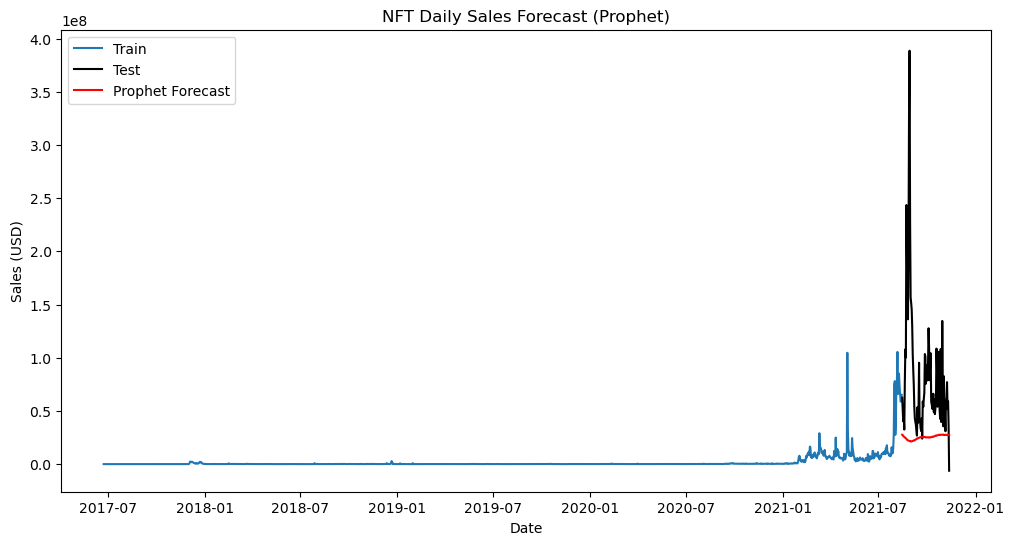

In [43]:
# Plot test forecast

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Sales_USD'], label="Train")
plt.plot(test.index, test['Sales_USD'], label="Test", color='black')
plt.plot(test.index, preds_orig, label="Prophet Forecast", color='red')
plt.title("NFT Daily Sales Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.show()

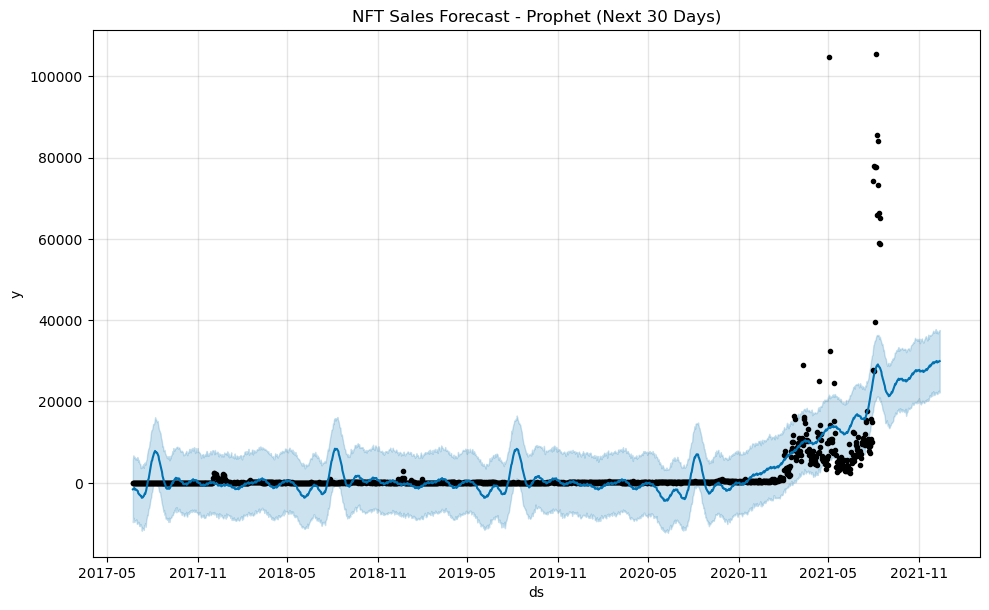

In [44]:
# Plot future 30-day forecast

model.plot(forecast)
plt.title("NFT Sales Forecast - Prophet (Next 30 Days)")
plt.show()

In [45]:
# Fit ARIMA
arima_model = ARIMA(train['Sales_USD'], order=(5,1,0))  # you can tune order
arima_fit = arima_model.fit()

In [47]:
# ARIMA predictions
arima_preds = arima_fit.forecast(steps=len(test))

# MAE
mae_arima = mean_absolute_error(test['Sales_USD'], arima_preds)

# RMSE (compute manually)
rmse_arima = np.sqrt(mean_squared_error(test['Sales_USD'], arima_preds))

print(f"ARIMA → MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")

ARIMA → MAE: 38181526.72, RMSE: 64367333.41


In [49]:
from statsmodels.tsa.arima.model import ARIMA

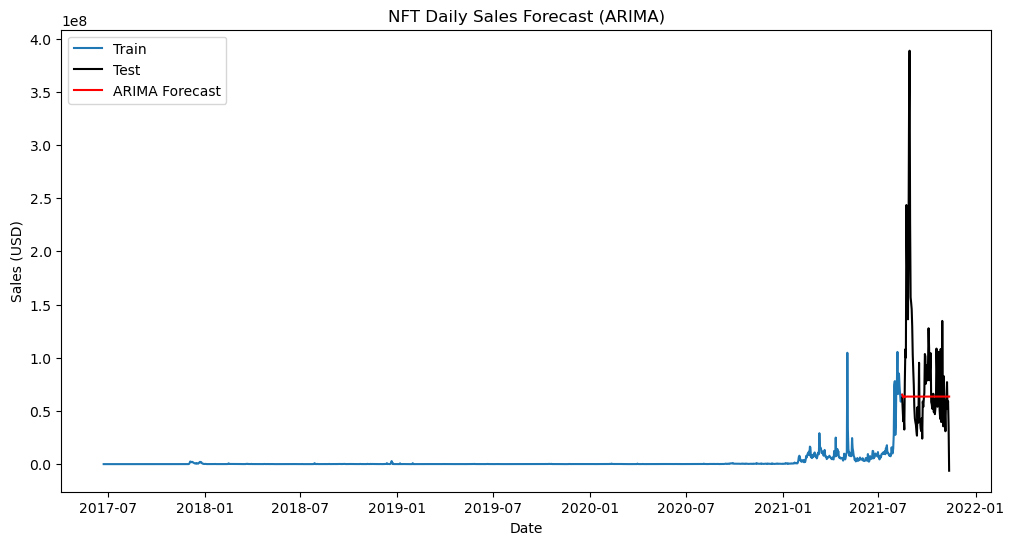

In [50]:
# Forecast on test period
arima_preds = arima_fit.forecast(steps=len(test))
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Sales_USD'], label='Train')
plt.plot(test.index, test['Sales_USD'], label='Test', color='black')
plt.plot(test.index, arima_preds, label='ARIMA Forecast', color='red')
plt.title("NFT Daily Sales Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.show()


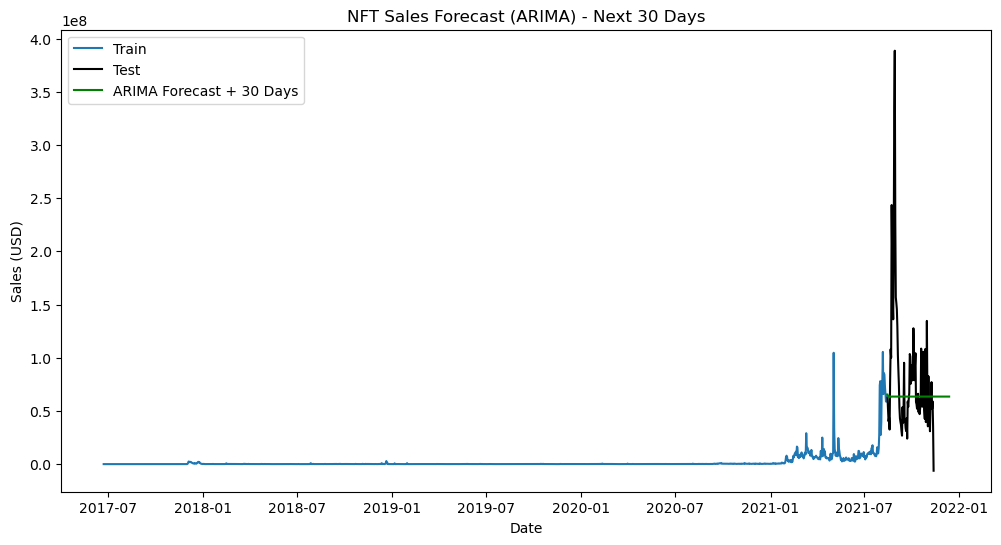

In [51]:
# Forecast next 30 days beyond test set
future_steps = 30
arima_future = arima_fit.forecast(steps=len(test)+future_steps)

# Combine test + future
future_index = pd.date_range(start=test.index[0], periods=len(test)+future_steps, freq='D')
arima_future_series = pd.Series(arima_future, index=future_index)

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Sales_USD'], label='Train')
plt.plot(test.index, test['Sales_USD'], label='Test', color='black')
plt.plot(arima_future_series.index, arima_future_series.values, label='ARIMA Forecast + 30 Days', color='green')
plt.title("NFT Sales Forecast (ARIMA) - Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.show()

In [52]:
# Ensure forecasts are aligned with test + future dates
future_steps = 30
# ARIMA future index
arima_future_index = pd.date_range(start=test.index[0], periods=len(test)+future_steps, freq='D')
arima_future_series = pd.Series(arima_fit.forecast(steps=len(test)+future_steps), index=arima_future_index)

In [53]:
# Prophet future predictions (already have forecast from Prophet)
prophet_forecast_series = forecast.set_index('ds')['yhat']

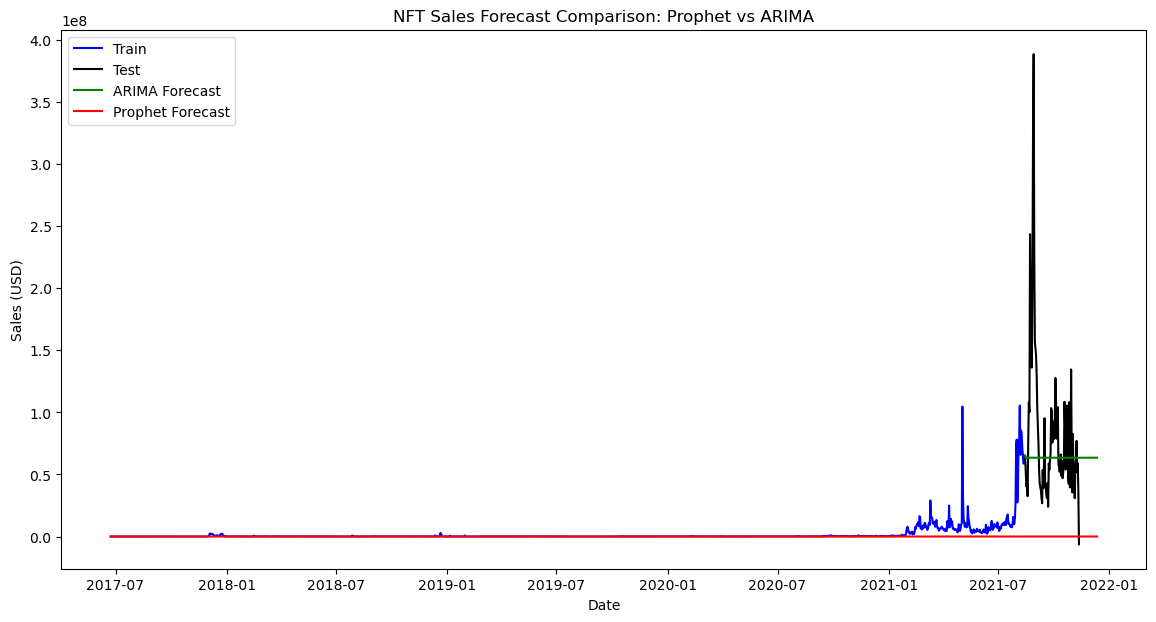

In [54]:
# Plot combined forecasts
plt.figure(figsize=(14,7))
plt.plot(train.index, train['Sales_USD'], label='Train', color='blue')
plt.plot(test.index, test['Sales_USD'], label='Test', color='black')
plt.plot(arima_future_series.index, arima_future_series.values, label='ARIMA Forecast', color='green')
plt.plot(prophet_forecast_series.index, prophet_forecast_series.values, label='Prophet Forecast', color='red')
plt.title("NFT Sales Forecast Comparison: Prophet vs ARIMA")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.show()

In [55]:
# Prophet predictions for the test period
prophet_preds = forecast.set_index('ds').loc[test.index, 'yhat']

# ARIMA predictions for the test period
arima_preds = arima_fit.forecast(steps=len(test))

# MAE
mae_prophet = mean_absolute_error(test['Sales_USD'], prophet_preds)
mae_arima = mean_absolute_error(test['Sales_USD'], arima_preds)

# RMSE
rmse_prophet = np.sqrt(mean_squared_error(test['Sales_USD'], prophet_preds))
rmse_arima = np.sqrt(mean_squared_error(test['Sales_USD'], arima_preds))

print(f"Prophet → MAE: {mae_prophet:,.2f}, RMSE: {rmse_prophet:,.2f}")
print(f"ARIMA → MAE: {mae_arima:,.2f}, RMSE: {rmse_arima:,.2f}")

Prophet → MAE: 82,563,784.10, RMSE: 102,851,268.75
ARIMA → MAE: 38,181,526.72, RMSE: 64,367,333.41


In [56]:
# Forecast horizon (30 days beyond test)
future_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=30)

# ARIMA 30-day forecast
arima_future = arima_fit.forecast(steps=30)

# Prophet 30-day forecast
prophet_future = forecast.set_index('ds').loc[future_dates, 'yhat']

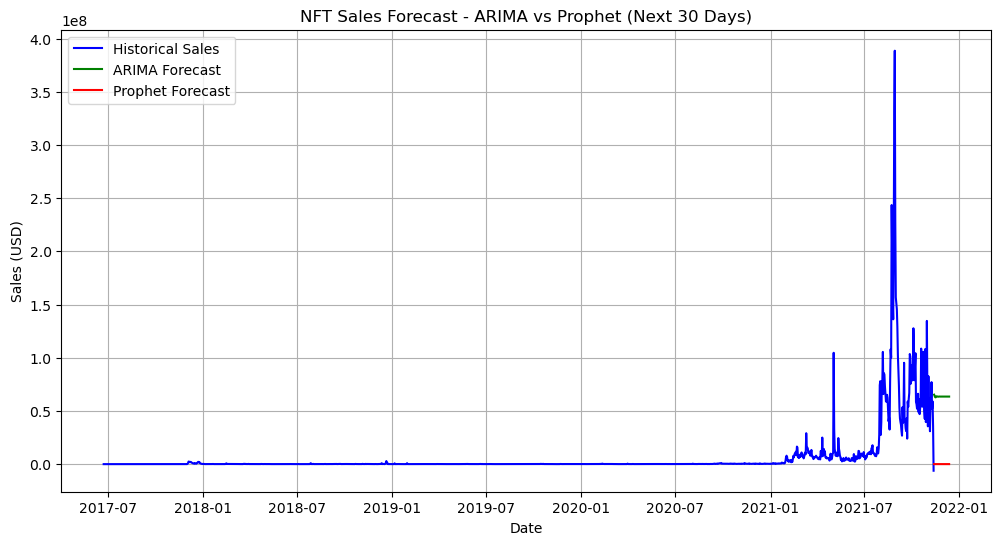

In [57]:
# Plot

plt.figure(figsize=(12,6))
plt.plot(df_model.index, df_model['Sales_USD'], label='Historical Sales', color='blue')
plt.plot(future_dates, arima_future, label='ARIMA Forecast', color='green')
plt.plot(future_dates, prophet_future, label='Prophet Forecast', color='red')
plt.title("NFT Sales Forecast - ARIMA vs Prophet (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# ARIMA 30-day forecast with confidence interval
arima_forecast = arima_fit.get_forecast(steps=30)
arima_mean = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()

In [59]:
# Prophet 30-day forecast with uncertainty interval
future_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=30)
prophet_future = forecast.set_index('ds').loc[future_dates]
prophet_mean = prophet_future['yhat']
prophet_lower = prophet_future['yhat_lower']
prophet_upper = prophet_future['yhat_upper']

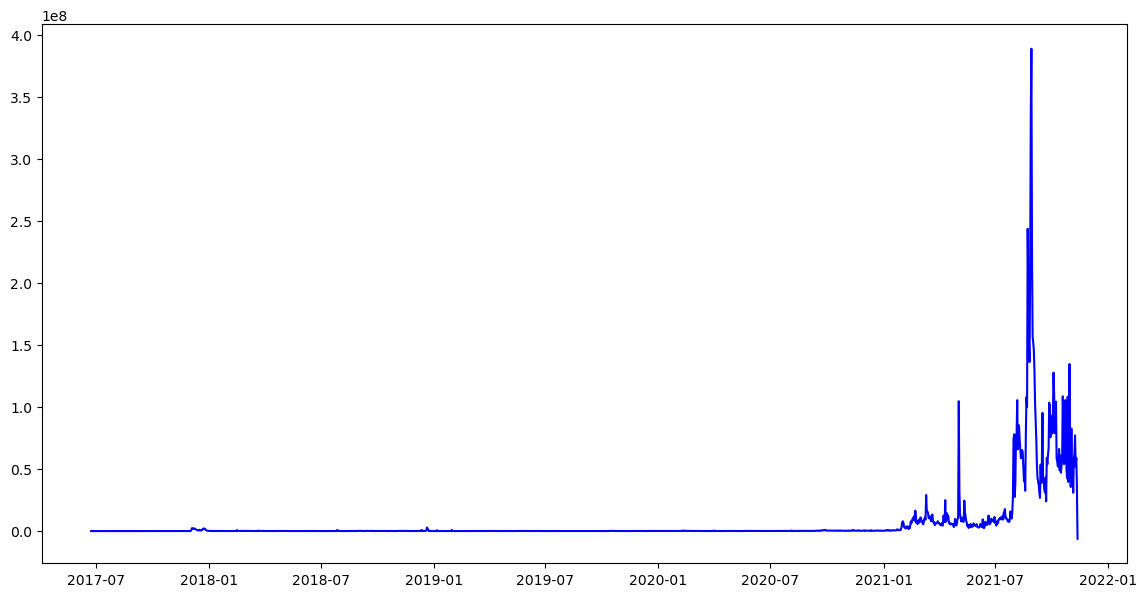

In [60]:
# Plot
plt.figure(figsize=(14,7))
plt.plot(df_model.index, df_model['Sales_USD'], label='Historical Sales', color='blue')

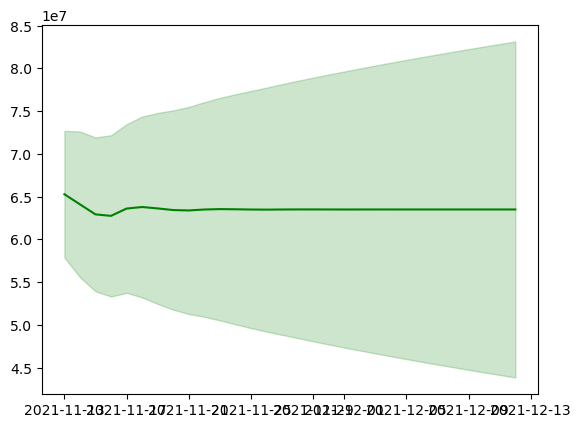

In [61]:
# ARIMA forecast
plt.plot(future_dates, arima_mean, label='ARIMA Forecast', color='green')
plt.fill_between(future_dates, arima_ci['lower Sales_USD'], arima_ci['upper Sales_USD'],
                 color='green', alpha=0.2)

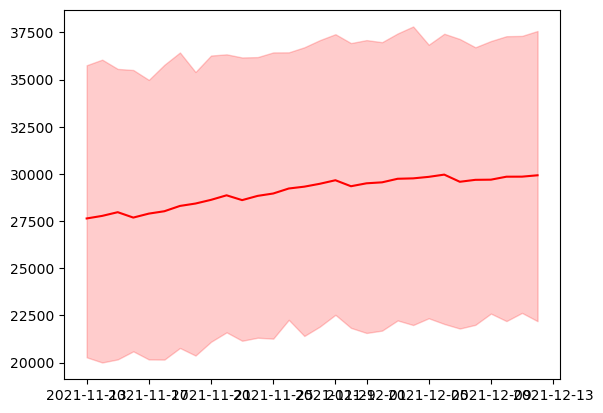

In [62]:
# Prophet forecast
plt.plot(future_dates, prophet_mean, label='Prophet Forecast', color='red')
plt.fill_between(future_dates, prophet_lower, prophet_upper, color='red', alpha=0.2)

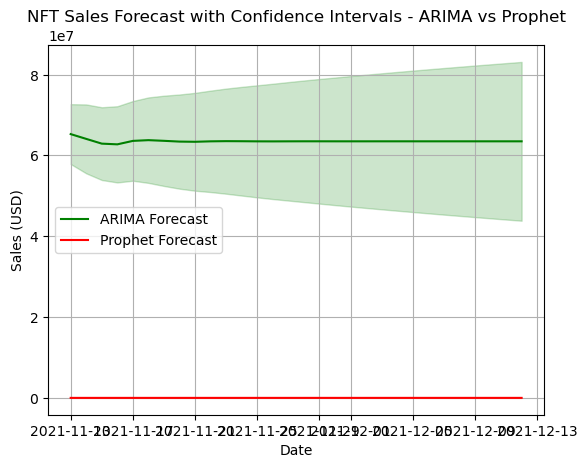

In [65]:
# ARIMA forecast
plt.plot(future_dates, arima_mean, label='ARIMA Forecast', color='green')
plt.fill_between(future_dates, arima_ci['lower Sales_USD'], arima_ci['upper Sales_USD'],
                 color='green', alpha=0.2)

# Prophet forecast
plt.plot(future_dates, prophet_mean, label='Prophet Forecast', color='red')
plt.fill_between(future_dates, prophet_lower, prophet_upper, color='red', alpha=0.2)

plt.title("NFT Sales Forecast with Confidence Intervals - ARIMA vs Prophet")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [66]:
# Create a summary DataFrame
model_comparison = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA'],
    'MAE': [57789002.01, 38181526.72],
    'RMSE': [84642957.17, 64367333.41]
})

# Format numbers for readability
model_comparison['MAE'] = model_comparison['MAE'].apply(lambda x: f"${x:,.2f}")
model_comparison['RMSE'] = model_comparison['RMSE'].apply(lambda x: f"${x:,.2f}")

model_comparison

,Model,MAE,RMSE
0,Prophet,"$57,789,002.01","$84,642,957.17"
1,ARIMA,"$38,181,526.72","$64,367,333.41"


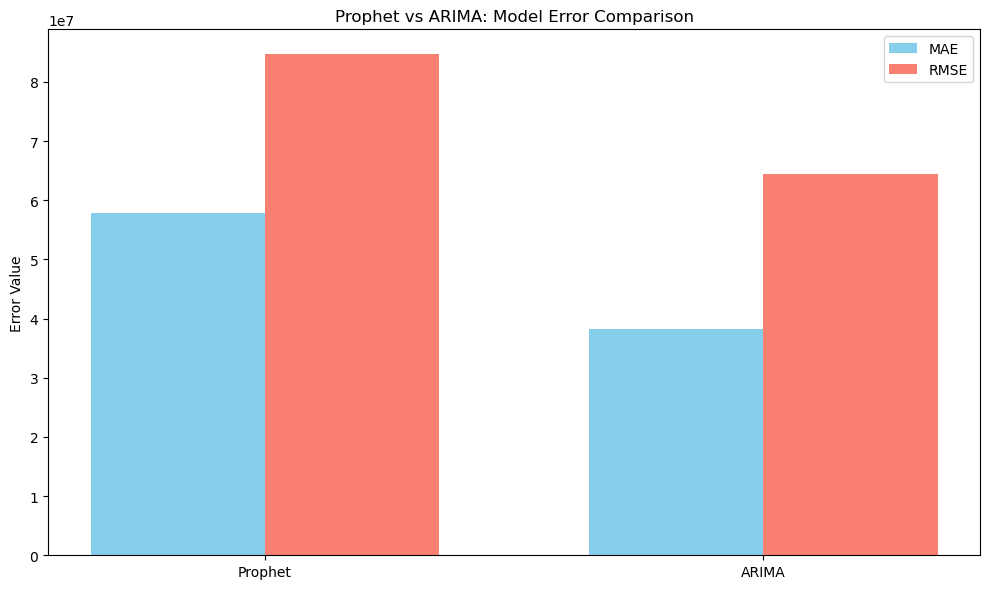

In [67]:
# Numeric values (without formatting)
mae_values = [57789002.01, 38181526.72]
rmse_values = [84642957.17, 64367333.41]
models = ['Prophet', 'ARIMA']

# Bar width and positions
x = range(len(models))
width = 0.35

# Plot
plt.figure(figsize=(10,6))
plt.bar(x, mae_values, width=width, label='MAE', color='skyblue')
plt.bar([i + width for i in x], rmse_values, width=width, label='RMSE', color='salmon')

# Labels and title
plt.xticks([i + width/2 for i in x], models)
plt.ylabel('Error Value')
plt.title('Prophet vs ARIMA: Model Error Comparison')
plt.legend()
plt.tight_layout()
plt.show()

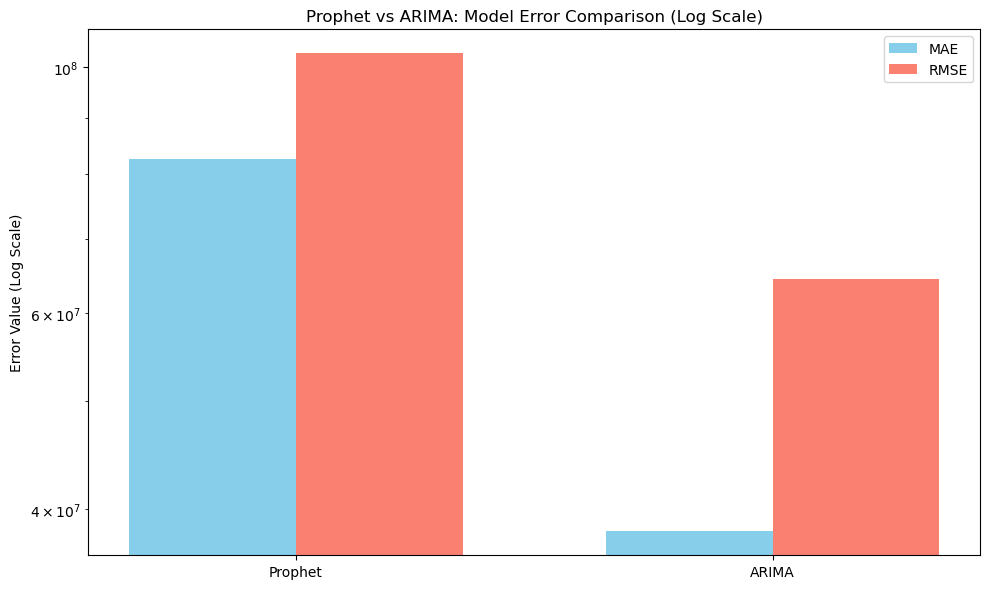

In [69]:
# Numeric values
mae_values = [82563784.10, 38181526.72]  # Prophet, ARIMA
rmse_values = [102851268.75, 64367333.41]
models = ['Prophet', 'ARIMA']

# Bar width and positions
x = np.arange(len(models))
width = 0.35

# Plot
plt.figure(figsize=(10,6))
plt.bar(x, mae_values, width=width, label='MAE', color='skyblue')
plt.bar(x + width, rmse_values, width=width, label='RMSE', color='salmon')

# Log scale for y-axis
plt.yscale('log')

# Labels and title
plt.xticks(x + width/2, models)
plt.ylabel('Error Value (Log Scale)')
plt.title('Prophet vs ARIMA: Model Error Comparison (Log Scale)')
plt.legend()
plt.tight_layout()
plt.show()

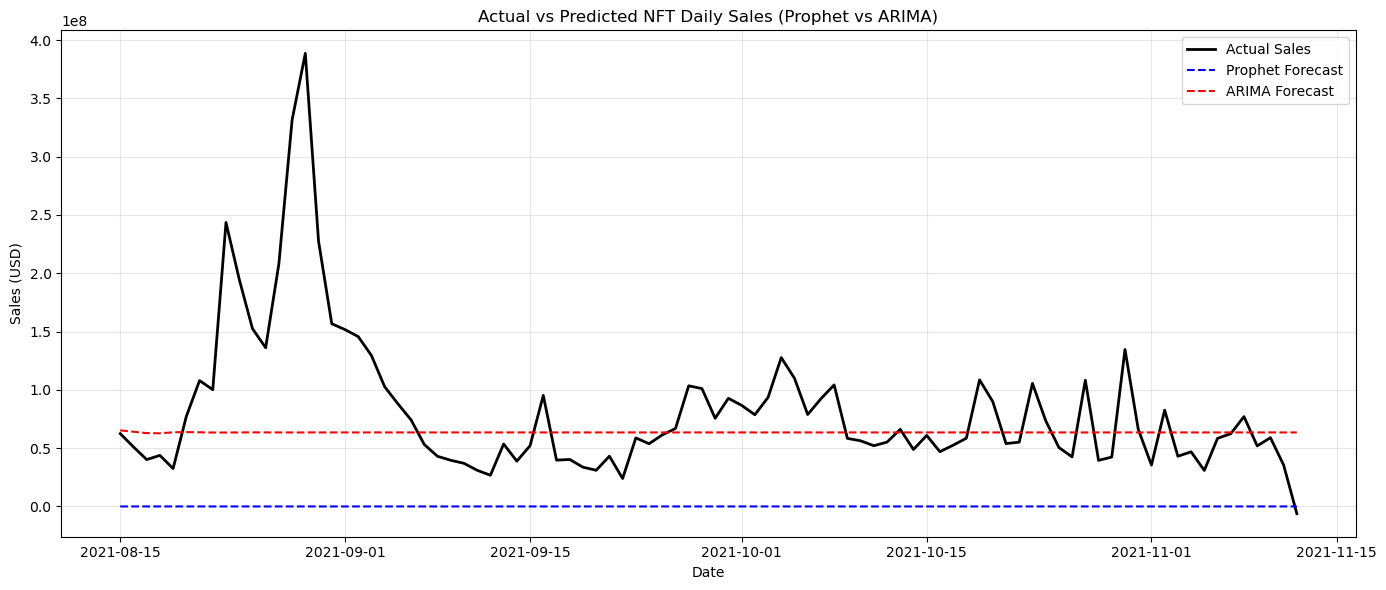

In [70]:
plt.figure(figsize=(14,6))

# Actual sales
plt.plot(test.index, test['Sales_USD'], label='Actual Sales', color='black', linewidth=2)

# Prophet predictions
plt.plot(test.index, preds, label='Prophet Forecast', color='blue', linestyle='--')

# ARIMA predictions
plt.plot(test.index, arima_preds, label='ARIMA Forecast', color='red', linestyle='--')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Actual vs Predicted NFT Daily Sales (Prophet vs ARIMA)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

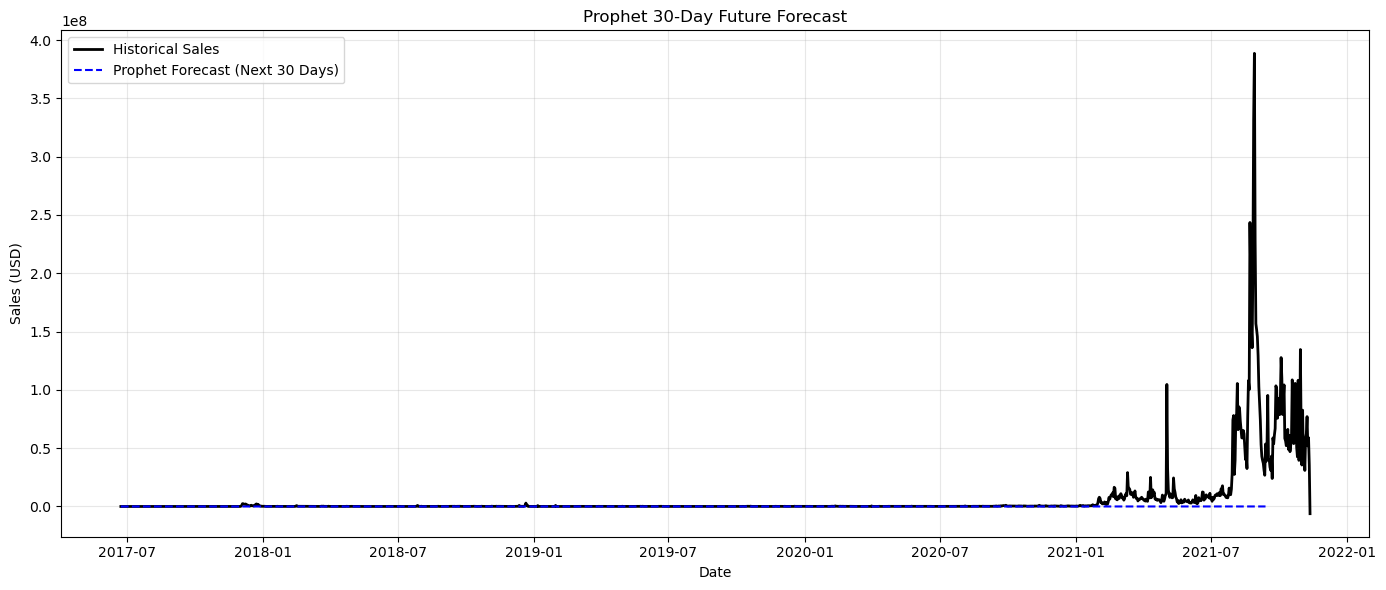

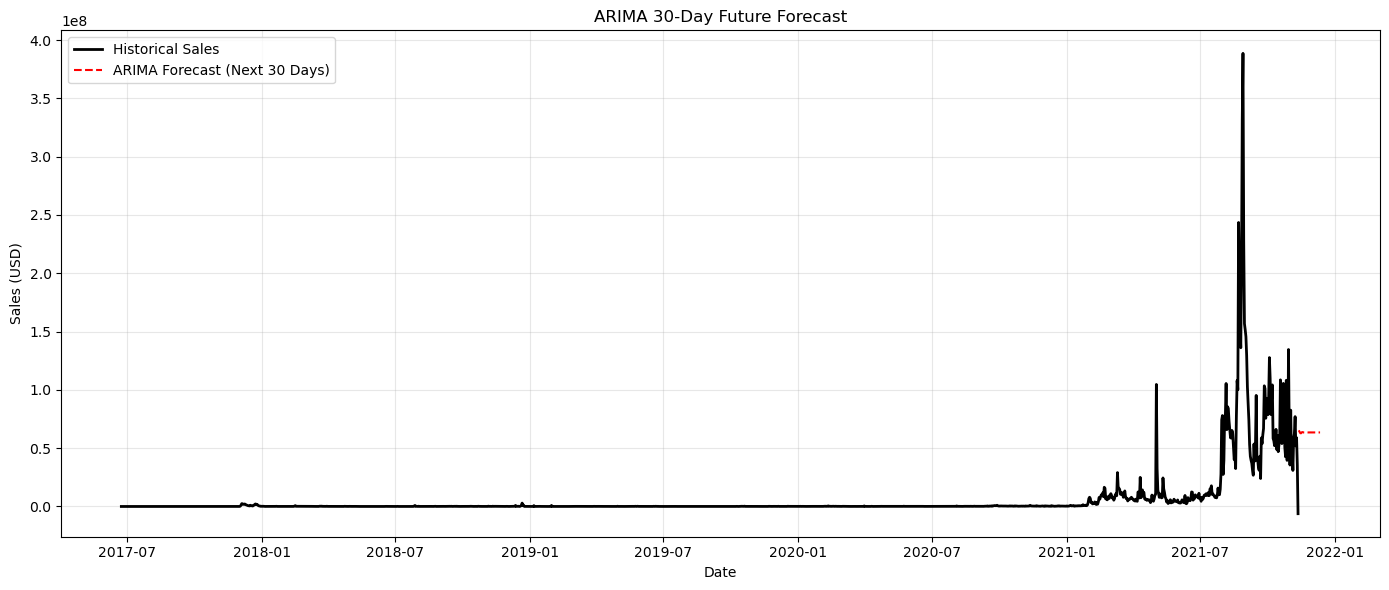

In [71]:
# --- Prophet 30-day future forecast ---
future_dates = model.make_future_dataframe(periods=30)
forecast_future = model.predict(future_dates)

plt.figure(figsize=(14,6))

# Historical sales
plt.plot(df_model.index, df_model['Sales_USD'], label='Historical Sales', color='black', linewidth=2)

# Prophet 30-day forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Prophet Forecast (Next 30 Days)', color='blue', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Prophet 30-Day Future Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- ARIMA 30-day future forecast ---
arima_future_preds = arima_fit.forecast(steps=30)
arima_future_index = pd.date_range(start=df_model.index[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(14,6))
plt.plot(df_model.index, df_model['Sales_USD'], label='Historical Sales', color='black', linewidth=2)
plt.plot(arima_future_index, arima_future_preds, label='ARIMA Forecast (Next 30 Days)', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('ARIMA 30-Day Future Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

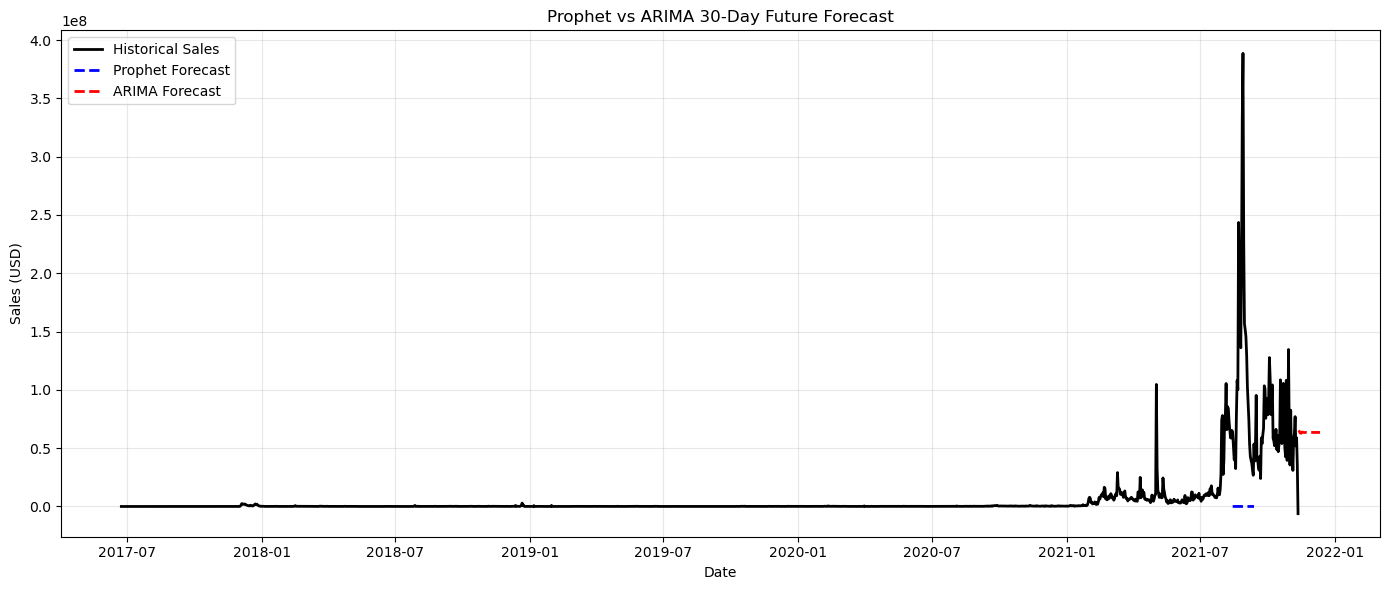

In [72]:
# ARIMA future forecast index
arima_future_index = pd.date_range(start=df_model.index[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(14,6))

# Historical sales
plt.plot(df_model.index, df_model['Sales_USD'], label='Historical Sales', color='black', linewidth=2)

# Prophet 30-day forecast
plt.plot(forecast_future['ds'][-30:], forecast_future['yhat'][-30:], label='Prophet Forecast', color='blue', linestyle='--', linewidth=2)

# ARIMA 30-day forecast
plt.plot(arima_future_index, arima_future_preds, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.title('Prophet vs ARIMA 30-Day Future Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [73]:
results = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA'],
    'MAE': [mae_prophet, mae_arima],
    'RMSE': [rmse_prophet, rmse_arima]
})

print(results)

     Model           MAE          RMSE
0  Prophet  8.256378e+07  1.028513e+08
1    ARIMA  3.818153e+07  6.436733e+07
